# Dimensionality

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
import torch

from tqdm.notebook import tqdm, trange

from main import *

params = {
    'text.usetex': True,
    'font.family': 'sans serif',
    'text.latex.preamble': r'\usepackage{amsfonts}',
}
matplotlib.rcParams.update(params)

## Load model

In [ ]:
def load_exp(name, step="last", log=True, dataloaders=False):
    """ Load an experiment with a given name. step can be an integer, "best", or "last" (default). """
    exp_dir = Path("models") / name

    with open(exp_dir / "args.json") as f:
        args_dict = json.load(f)

    ctx = TrainingContext(**args_dict, step=step, key_remap=None, seed=None, dataloaders=dataloaders, writer=False)
    if log:
        print(f"{name}: retrieved model at step {ctx.step} and test loss {ctx.test_perf.loss:.2e}")

    # Disable DataParallel (needed for Hessian computation)
    ctx.model.network = ctx.model.network.module

    # Put in eval mode and disable gradients with respect to all parameters.
    ctx.model.eval()
    for p in ctx.model.parameters():
        p.requires_grad = False

    return ctx

ctxs = {
    # "color": load_exp("finalclean_imagenet64_color_lr0.0005_1Msteps10decays", dataloaders=True),
    "grayscale": load_exp("finalclean_imagenet64_grayscale_lr0.0005_1Msteps10decays", dataloaders=True),
}
default_ctx = ctxs["grayscale"]
default_ctx.model.log_normalization_constant = 5.845e+03  # Calculated from energy_histogram.ipynb
device = default_ctx.device
dataset_info = default_ctx.dataset_info  # Grayscale!
d = dataset_info.dimension  # Grayscale!
# Dataloaders have horizontal flips.
# train_dataloader_color = ctxs["color"].new_dataloader(train=True, batch_size=1024)
# test_dataloader_color = ctxs["color"].new_dataloader(train=False, batch_size=1024)
train_dataloader_grayscale = ctxs["grayscale"].new_dataloader(train=True, batch_size=1024)
test_dataloader_grayscale = ctxs["grayscale"].new_dataloader(train=False, batch_size=1024)

finalclean_imagenet64_grayscale_lr0.0005_1Msteps10decays: retrieved model at step 1000000 and test loss 4.57e-01


## Reference images

<class 'numpy.ndarray'> (15, 64, 64, 3)
shape torch.Size([15, 3, 64, 64]), values in [0.000, 1.000] and around 0.506 +- 0.353
shape torch.Size([15, 1, 64, 64]), values in [0.000, 1.000] and around 0.519 +- 0.338


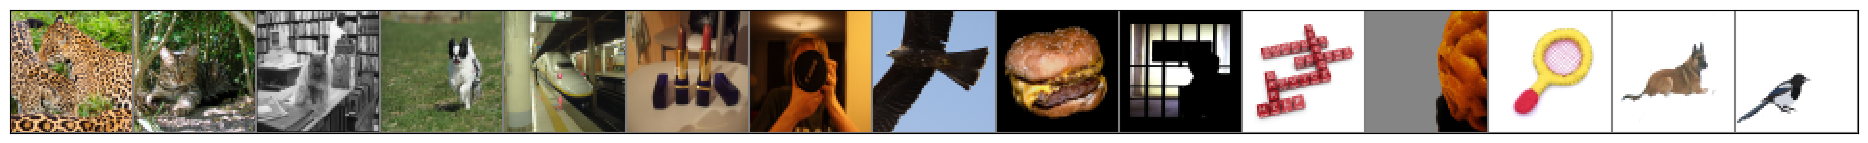

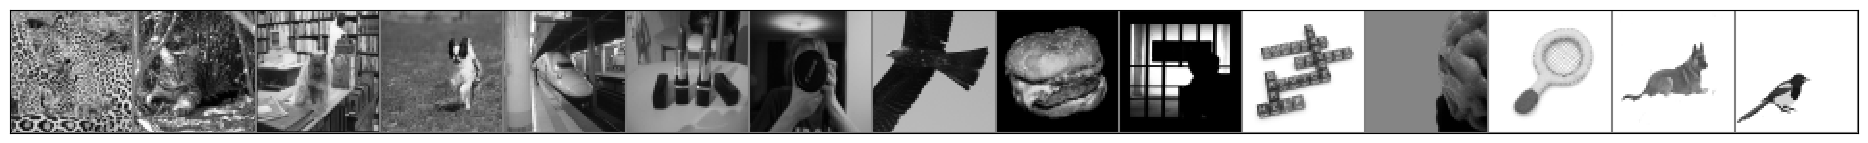

In [3]:
import torchvision.transforms.v2 as v2
from PIL import Image

n = 15
colormap = "plasma"
colors = matplotlib.colormaps.get_cmap(colormap)(np.linspace(0, 1, n))[:, :3]  # (N, 3)

color_transforms = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
grayscale_transforms = v2.Compose([v2.Grayscale(), v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
apply = lambda t, x: torch.stack([t(Image.fromarray(xx)) for xx in x], dim=0)

idx_ref = np.asarray([21143, 34295, 42627, 47510,  8718,  4375,  1266, 47346, 11592, 36426, 31424, 17305, 14457, 39755, 41191])
imgs_ref = test_dataloader_grayscale.dataset.data[idx_ref]  # (N, H, W, C) uint8 numpy array
print(type(imgs_ref), imgs_ref.shape)
imgs_ref_color = apply(color_transforms, imgs_ref)
imgs_ref_grayscale = apply(grayscale_transforms, imgs_ref)
print(tensor_summary_stats(imgs_ref_color), tensor_summary_stats(imgs_ref_grayscale), sep="\n")
plot_img(rearrange(imgs_ref_color, "n c h w -> 1 h n w c"), inches_per_pixel=0.025)
plot_img(rearrange(imgs_ref_grayscale, "n c h w -> 1 h n w c"), inches_per_pixel=0.025, cmap="gray")

## Computing energy as a function of noise

In [4]:
def avg_noise(ctx, x, t=0, num_noises=1_000, t_batch_size=50, noise_batch_size=1, get_score=False):
    """ (B..., C, H, W) and (T...) to (B..., T...). t is 0 by default.
    Averages over num_noises noise samples per image and noise level. Returns energy in dB/d. """
    energies, dimensionalities = [], []
    for t_chunk in tqdm(t.split(t_batch_size)):
        energy_tracker = BatchMeanTracker(axis=-1)
        dimensionality_tracker = BatchMeanTracker(axis=-1)
        for _ in range(ceil_div(num_noises, noise_batch_size)):
            input = model_input(clean=x, noise_level=t_chunk, num_noises=noise_batch_size)  # (B..., T..., N, C, H, W)
            output = ctx.model(input, compute_scores=get_score, create_graph=False)  # (B..., T..., N, [C, H, W])
            energy_tracker.update(output.energy)  # (B..., T..., N)
            if get_score:
                assert len(x.shape[:-3]) == t.ndim == 1  # Too lazy to fix unsqueeze of x
                x_unsq = x[:, None, None, :, :, :]
                mse = torch.sum((x_unsq - output.denoised) ** 2, dim=(-1, -2, -3))  # (B..., T..., N)
                dimensionality_tracker.update(mse / t_chunk[..., None])  # (B..., T..., N)
        energies.append(energy_tracker.mean())
        if get_score:
            dimensionalities.append(dimensionality_tracker.mean())
    energy = torch.cat(energies, dim=1)  # (B..., T...)
    energy = 10 * energy / (d * np.log(10)) # Convert to dBs/d
    dimensionality = torch.cat(dimensionalities, dim=1) if get_score else None  # (B..., T...)
    return energy, dimensionality

ts = 10 ** torch.linspace(-12, 3, 100, device=device)
energies, dimensionalities = avg_noise(ctxs["grayscale"], imgs_ref_grayscale.cuda(), t=ts, get_score=True)  # (B, T) where B = num images
torch.save((energies, dimensionalities), "outputs/dimensionalities_ref.pt")

  0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
def avg_data(ctx, t=0, batch_size=8, get_score=False):
    """ (T...) to (T...). t is 0 by default. Returns energy in dB/d. """
    energy_tracker = BatchMeanTracker(axis=0)
    dimensionality_tracker = BatchMeanTracker(axis=0)
    for x in tqdm(ctx.new_dataloader(train=False, batch_size=batch_size)):
        x = x[0].cuda()  # (B, C, H, W)
        input = model_input(clean=x, noise_level=t)  # (B, T..., C, H, W)
        output = ctx.model(input, compute_scores=get_score, create_graph=False)  # (B, T..., [C, H, W])
        energy_tracker.update(output.energy)  # (B, T...)
        if get_score:
            assert t.ndim == 1  # Too lazy to fix unsqueeze of x
            x_unsq = x[:, None, :, :, :]  # (B, 1..., C, H, W)
            mse = torch.sum((x_unsq - output.denoised) ** 2, dim=(-1, -2, -3))  # (B, T...)
            dimensionality_tracker.update(mse / t)  # (B, T...)
    energy = 10 * energy_tracker.mean() / (d * np.log(10))  # Convert to dBs/d
    dimensionality = dimensionality_tracker.mean() if get_score else None
    return energy, dimensionality

energies_avg, dimensionalities_avg = avg_data(ctxs["grayscale"], t=ts, get_score=True)  # (T,)
torch.save((energies_avg, dimensionalities_avg), "outputs/dimensionalities_avg.pt")

  0%|          | 0/6250 [00:00<?, ?it/s]

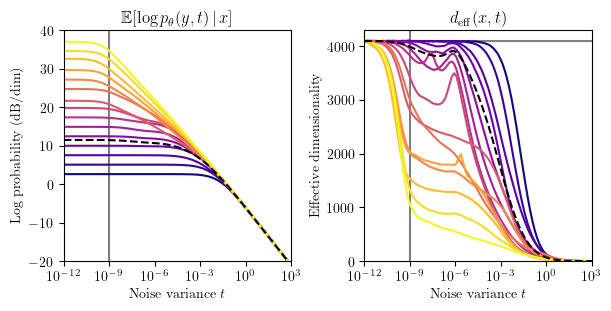

In [10]:
fig, axs = plt.subplots(figsize=(6, 3), ncols=2, nrows=1, sharex=True, sharey=False, layout="constrained")

plt.sca(axs[0])
plt.axvline(x=1e-9, color="tab:gray")
# plt.axvline(x=1e-6, color="tab:gray", linestyle=":")
plot_lines(*(-energies), x=ts, xscale="log", xlabel="Noise variance $t$", ylabel="Log probability (dB/dim)",
           title=r"$\mathbb{E}[\log p_{\theta}(y,t)\,|\,x]$", color=colors.tolist(), has_fig=True, grid=False)
plot_lines(-energies_avg, x=ts, xscale="log", xlabel="Noise variance $t$", ylabel="Log probability (dB/dim)",
           title=r"$\mathbb{E}[\log p_{\theta}(y,t)\,|\,x]$", color="black", linestyle="--", has_fig=True, grid=False)
plt.xlim(1e-12, 1e3)
plt.ylim(-20, 40)

plt.sca(axs[1])
plt.axvline(x=1e-9, color="tab:gray")
plt.axhline(y=d, color="tab:gray")
# plt.axvline(x=1e-6, color="tab:gray", linestyle=":")
plot_lines(*(dimensionalities), x=ts, xscale="log", xlabel="Noise variance $t$", ylabel="Effective dimensionality",
           title=r"$d_{\mathrm{eff}}(x,t)$", color=colors.tolist(), has_fig=True, grid=False)
plot_lines(dimensionalities_avg, x=ts, xscale="log", xlabel="Noise variance $t$", ylabel="Effective dimensionality",
           title=r"$d_{\mathrm{eff}}(x,t)$", color="black", linestyle="--", has_fig=True, grid=False)
plt.xlim(1e-12, 1e3)
plt.ylim(0, 4300)
plt.savefig("outputs/energy_landscape.pdf", transparent=True, bbox_inches="tight", pad_inches=0)
plt.show()

## Releasing GPU memory

In [6]:
1/0

ZeroDivisionError: division by zero

In [7]:
import gc
gc.collect()
torch.cuda.empty_cache()